In [429]:
import os
import re
import sys
from collections import Counter
from itertools import islice
from urllib.parse import urlparse, urlsplit, parse_qs, parse_qsl

import numpy as np
import parsel
import sklearn_crfsuite
from sklearn_crfsuite.metrics import flat_classification_report, sequence_accuracy_score
from sklearn.model_selection import cross_val_predict, GroupKFold

sys.path.insert(0, '..')
from autopager.storage import Storage
from autopager.htmlutils import (get_link_text, get_text_around_selector_list,
                                 get_link_href, get_selector_root)
from autopager.utils import (
    get_domain, normalize_whitespaces, normalize, ngrams, tokenize, ngrams_wb, replace_digits
)
from autopager.model import link_to_features, _num_tokens_feature, _elem_attr
from autopager import AUTOPAGER_LIMITS
from autopager.parserutils import (TagParser, MyHTMLParser, draw_scaled_page, position_check, compare_tag)
storage = Storage()
parser = MyHTMLParser()
tagParser = TagParser()

In [430]:
%%time
urls = [rec['Page URL'] for rec in storage.iter_records(contain_button = True, file_type='T')]
X_raw, y, page_positions = storage.get_Xy(contain_button = True, file_type='T')
print("pages: {}  domains: {}".format(len(urls), len({get_domain(url) for url in urls})))

Finish: Get Page 1 (Encoding: UTF-8)records ... (len: 303)
Finish: Get Page 2 (Encoding: UTF-8)records ... (len: 243)
Finish: Get Page 3 (Encoding: UTF-8)records ... (len: 119)
Finish: Get Page 4 (Encoding: UTF-8)records ... (len: 944)
Finish: Get Page 5 (Encoding: UTF-8)records ... (len: 93)
Finish: Get Page 6 (Encoding: UTF-8)records ... (len: 994)
Finish: Get Page 7 (Encoding: UTF-8)records ... (len: 1014)
Finish: Get Page 8 (Encoding: UTF-8)records ... (len: 7)
Finish: Get Page 9 (Encoding: UTF-8)records ... (len: 288)
Finish: Get Page 10 (Encoding: UTF-8)records ... (len: 678)
Finish: Get Page 11 (Encoding: UTF-8)records ... (len: 789)
Finish: Get Page 12 (Encoding: UTF-8)records ... (len: 814)
Finish: Get Page 13 (Encoding: UTF-8)records ... (len: 814)
Finish: Get Page 14 (Encoding: UTF-8)records ... (len: 171)
Finish: Get Page 15 (Encoding: UTF-8)records ... (len: 168)
Finish: Get Page 16 (Encoding: UTF-8)records ... (len: 91)
Finish: Get Page 17 (Encoding: UTF-8)records ... (le

Finish: Get Page 149 (Encoding: UTF-8)records ... (len: 365)
Finish: Get Page 150 (Encoding: UTF-8)records ... (len: 368)
Finish: Get Page 151 (Encoding: UTF-8)records ... (len: 369)
Finish: Get Page 152 (Encoding: cp1252)records ... (len: 294)
Finish: Get Page 153 (Encoding: UTF-8)records ... (len: 271)
Finish: Get Page 154 (Encoding: UTF-8)records ... (len: 300)
Finish: Get Page 155 (Encoding: UTF-8)records ... (len: 314)
Finish: Get Page 156 (Encoding: UTF-8)records ... (len: 278)
Finish: Get Page 157 (Encoding: UTF-8)records ... (len: 288)
Finish: Get Page 158 (Encoding: UTF-8)records ... (len: 178)
Finish: Get Page 159 (Encoding: UTF-8)records ... (len: 108)
Finish: Get Page 160 (Encoding: UTF-8)records ... (len: 98)
Finish: Get Page 161 (Encoding: UTF-8)records ... (len: 101)
Finish: Get Page 162 (Encoding: UTF-8)records ... (len: 308)
Finish: Get Page 163 (Encoding: UTF-8)records ... (len: 298)
Finish: Get Page 164 (Encoding: UTF-8)records ... (len: 285)
Finish: Get Page 165 (En

Finish: Get Page 291 (Encoding: UTF-8)records ... (len: 331)
Finish: Get Page 292 (Encoding: UTF-8)records ... (len: 280)
Finish: Get Page 293 (Encoding: UTF-8)records ... (len: 74)
Finish: Get Page 294 (Encoding: UTF-8)records ... (len: 63)
Finish: Get Page 295 (Encoding: UTF-8)records ... (len: 65)
Finish: Get Page 296 (Encoding: UTF-8)records ... (len: 20)
Finish: Get Page 297 (Encoding: UTF-8)records ... (len: 367)
Finish: Get Page 298 (Encoding: UTF-8)records ... (len: 371)
Finish: Get Page 299 (Encoding: UTF-8)records ... (len: 361)
Finish: Get Page 300 (Encoding: UTF-8)records ... (len: 361)
Finish: Get Page 301 (Encoding: UTF-8)records ... (len: 364)
Finish: Get Page 302 (Encoding: UTF-8)records ... (len: 170)
Finish: Get Page 303 (Encoding: UTF-8)records ... (len: 154)
Finish: Get Page 304 (Encoding: cp1252)records ... (len: 117)
Finish: Get Page 305 (Encoding: UTF-8)records ... (len: 1987)
Finish: Get Page 306 (Encoding: UTF-8)records ... (len: 59)
Finish: Get Page 307 (Encod

## Use href as feature

In [474]:
%%time
# XXX: these functions should be copy-pasted from autopager/model.py

def _as_list(generator, limit=None):
    """
    >>> _as_list(ngrams_wb("text", 2, 2), 0)
    []
    >>> _as_list(ngrams_wb("text", 2, 2), 2)
    ['te', 'ex']
    >>> _as_list(ngrams_wb("text", 2, 2))
    ['te', 'ex', 'xt']
    """
    return list(generator if limit is None else islice(generator, 0, limit))


def link_to_features(link):
    text = normalize(get_link_text(link))
    href = get_link_href(link)
    if href is None:
        href = ""
    p = urlsplit(href)
    query_parsed = parse_qsl(p.query) #parse query string from path
    query_param_names = [k.lower() for k, v in query_parsed]
    query_param_names_ngrams = _as_list(ngrams_wb(
        " ".join([normalize(name) for name in query_param_names]), 3, 5, True
    ))
    parent = link.xpath('..').extract()
    parent = get_first_tag(parser, parent[0])
    elem = get_selector_root(link)
    elem_target = _elem_attr(elem, 'target')
    elem_rel = _elem_attr(elem, 'rel')
    # Classes of link itself and all its children.
    # It is common to have e.g. span elements with fontawesome
    # arrow icon classes inside <a> links.
    self_and_children_classes = ' '.join(link.xpath(".//@class").extract())
    parent_classes = ' '.join(link.xpath('../@class').extract())
    css_classes = normalize(parent_classes + ' ' + self_and_children_classes)

    return {
        'bias': 3.0,
        'isdigit': text.isdigit(),
        'isalpha': text.isalpha(),
#         'elem-target': elem_target, # Not effective
#         'elem-rel': elem_rel, # Not effective
        'num-tokens%s' % _num_tokens_feature(text): 1.0,

        'text': _as_list(ngrams_wb(replace_digits(text), 2, 5),
                         AUTOPAGER_LIMITS.max_text_features),
        'text-exact': replace_digits(text.strip()[:20].strip()),
        'parent-tag': parent, #Really good at Normal, but get worse in EVENT_SOURCE
        'class': _as_list(ngrams_wb(css_classes, 4, 5),
                          AUTOPAGER_LIMITS.max_css_features),
        'class_disabled': True if 'disabled' in css_classes else False, #Effective
        'query': query_param_names_ngrams,
        'has-href': False if href is "" else True,
        'path-has-page': 'page' in p.path.lower(),
        'path-has-pageXX': re.search(r'[/-](?:p|page\w?)/?\d+', p.path.lower()) is not None,
        'path-has-number': any(part.isdigit() for part in p.path.split('/')),

        'href-has-year': re.search('20\d\d', href) is not None,
#         'href-had-self-redirection': '#' in href # effect to bad performance
    }


def page_to_features(xseq, positions):
    features = [link_to_features(a) for a in xseq]
    around = get_text_around_selector_list(xseq, max_length=15)

    # weight is less than 1 because there is a lot of duplicate information
    # in these ngrams and so we want to regularize them stronger
    # (as if they are a single feature, not many features)
    k = 0.2
    for feat, (before, after), (pos_x, pos_y) in zip(features, around, positions):
        feat['text-before'] = {n: k for n in _as_list(ngrams_wb(normalize(before), 5, 5))}
        feat['text-after'] = {n: k for n in _as_list(ngrams_wb(normalize(after), 5, 5))}
        feat['position-x'] = pos_x #Good
        feat['position-y'] = pos_y #Good
    return features

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 10.7 µs


In [462]:
X = [page_to_features(xseq, positions) for xseq, positions in zip(X_raw, page_positions)]

## Not use href as feature

In [463]:
groups = [get_domain(url) for url in urls]

In [464]:
# TRAIN_SIZE = 80
# X_train, y_train = X[:TRAIN_SIZE], y[:TRAIN_SIZE]
# X_test, y_test = X[TRAIN_SIZE:], y[TRAIN_SIZE:]
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.001,
    c2=0.05,
    max_iterations=100,
    all_possible_transitions=True,
    verbose=False,
)
# crf.fit(X_train, y_train, X_test, y_test)

In [465]:
crf

/home/sam/DL/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.001, c2=0.05,
    keep_tempfiles=None, max_iterations=100)

We must be careful when splitting the dataset into training and
evaluation parts: pages from the same domain should be in the same
"bin". There could be several pages from the same domain, and these
pages may have duplicate or similar link patterns
(e.g. a particular CSS class for paginator links). If we put one such page in a training dataset and another in
an evaluation dataset then the metrics will be too optimistic,
and they can make us to choose wrong features/models.

In [466]:
crf.fit(X, y)
# crf.attributes_
crf.num_attributes_

23213

In [467]:
crf.classes_

['O', 'PAGE', 'NEXT', 'PREV']

In [468]:
# [a for a in sorted(crf.attributes_) if a.startswith('id')]

## What are important features?

In [469]:
import eli5

In [470]:
# XXX: weight for correlated features don't show their importance
# XXX: weights for features of different scale don't show their importance
# (e.g. coefficients to text-after and text-before features are high, but only
# because input is scaled down for these features)

eli5.show_weights(crf, top=50)

/home/sam/DL/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


## Let's check errors the model is making

In [39]:
group_kfold = GroupKFold(n_splits=6)
groups = [get_domain(url) for url in urls]
y_pred = cross_val_predict(crf, X, y, cv=group_kfold, groups=groups, n_jobs=-1)

errors = np.asarray(y) != np.asarray(y_pred)
error_rows = np.asarray(list(storage.iter_records(contain_button=True,file_type='T')))[errors]
error_links = np.asarray(X_raw)[errors]
error_y_pred = y_pred[errors]
error_y_true = np.asarray(y)[errors]

/home/sam/DL/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


In [52]:
error_rows

array([OrderedDict([('Checked', 'T'), ('File Name', '1'), ('Page URL', 'https://forums.oneplus.net/threads/marsh-cm13.405700/'), ('Page Type', 'a'), ('Encoding', 'UTF-8'), ('PREV', ''), ('PAGE', '.currentPage , .scrollable a'), ('NEXT', '.text'), ('LAST', '.PageNavNext+ a'), ('FIRST', ''), ('failed', '')]),
       OrderedDict([('Checked', 'T'), ('File Name', '2'), ('Page URL', 'https://forums.oneplus.net/threads/marsh-cm13.405700/page-5'), ('Page Type', 'a'), ('Encoding', 'UTF-8'), ('PREV', '.text:nth-child(1)'), ('PAGE', '.currentPage , .scrollable a'), ('NEXT', 'a+ .text'), ('LAST', '.PageNavNext+ a'), ('FIRST', '.text+ a'), ('failed', '')]),
       OrderedDict([('Checked', 'T'), ('File Name', '3'), ('Page URL', 'https://forums.oneplus.com/threads/marsh-cm13.405700/page-349'), ('Page Type', 'a'), ('Encoding', 'UTF-8'), ('PREV', '.text'), ('PAGE', '.currentPage , .scrollable a'), ('NEXT', ''), ('LAST', ''), ('FIRST', '.text+ a'), ('failed', '')]),
       OrderedDict([('Checked', 'T'),

In [50]:
y_pred

array([list(['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'PAGE', 'PAGE', 'PAGE', 'PAGE', 'PAGE', 'O', 'PAGE', 'NEXT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '

In [51]:
test_y_pred

[['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'PAGE',
  'PAGE',
  'PAGE',
  'PAGE',
  'PAGE',
  'PAGE',
  'PAGE',
  'PAGE',
  'PAGE',
  'O',
  'NEXT',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O

In [43]:
errors

array([ True,  True,  True, False, False,  True, False, False, False,
       False,  True, False, False, False, False, False, False,  True,
        True, False, False,  True,  True, False, False,  True, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False,  True, False, False, False, False, False,  True,  True,
        True,  True,  True,  True, False,  True,  True, False,  True,
        True, False,  True,  True, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True, False,  True,  True, False,  True,  True,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False,  True, False,  True,  True, False, False, False, False,
        True,  True, False,  True, False, False, False,  True, False,
        True, False,  True,  True, False,  True, False, False, False,
       False, False,

In [20]:
for links, yseq_pred, yseq_true, row in zip(error_links, error_y_pred, error_y_true, error_rows):
    print(row['Page URL'])
    for label_correct, label_pred, link in zip(yseq_true, yseq_pred, links.extract()):
        if label_correct != label_pred:
            print("CORRECT: %4s, PREDICT: %4s, LINK: %s" % (label_correct, label_pred, link))
    print("\n")

https://forums.oneplus.net/threads/marsh-cm13.405700/
CORRECT: PAGE, PREDICT:    O, LINK: <a href="threads/marsh-cm13.405700/" class="currentPage " rel="start">1</a>
CORRECT: PAGE, PREDICT:    O, LINK: <a href="threads/marsh-cm13.405700/" class="currentPage " rel="start">1</a>


https://forums.oneplus.net/threads/marsh-cm13.405700/page-5
CORRECT: PAGE, PREDICT:    O, LINK: <a href="threads/marsh-cm13.405700/" class="" rel="start">1</a>
CORRECT: PAGE, PREDICT:    O, LINK: <a href="threads/marsh-cm13.405700/" class="" rel="start">1</a>


https://forums.oneplus.com/threads/marsh-cm13.405700/page-349
CORRECT: PAGE, PREDICT:    O, LINK: <a href="threads/marsh-cm13.405700/" class="" rel="start">1</a>
CORRECT: PAGE, PREDICT:    O, LINK: <a href="threads/marsh-cm13.405700/page-344" class="">344</a>
CORRECT: PAGE, PREDICT:    O, LINK: <a href="threads/marsh-cm13.405700/page-345" class="">345</a>
CORRECT: PAGE, PREDICT:    O, LINK: <a href="threads/marsh-cm13.405700/page-346" class="">346</a>
CO

## Unused code

In [25]:
def _url_parts(url):
    p = urlsplit(url)
    args = parse_qsl(p.query)
    argnames = [name for name, value in args]
    return p.netloc, set(p.path.split('/')) | set(args) | set(argnames)

def url_distance(url1, url2):
    netloc1, parts1 = _url_parts(url1)
    netloc2, parts2 = _url_parts(url2)
    if netloc1 != netloc2:
        return 1.0
    if not parts1 and not parts2:
        return 0.0
    return 1 - len(parts1 & parts2) / len(parts1 | parts2)

#         dist = url_distance(url, href)
#         if dist == 0:
#             feat['url-distance=0'] = 1.0
#         elif dist == 1.0:
#             feat['url-distance=1'] = 1.0
#         else:
#             feat['url-distance=k'] = dist


url_distance('http://example.com/foo/345?page=2', 'http://example.com/foo/345?page=4')

0.33333333333333337

In [26]:
# def guess_page_number(link):
#     text = get_link_text(link).strip()
#     if text.isdigit():
#         return int(text)
#     return None

# def number_pattern2(pattern):
#     txt = re.sub('X+', 'X', pattern)
# #     txt = re.sub('C+', 'C', txt)
#     return txt

#     pagenums = [guess_page_number(a) for a in xseq]
# #     print(pagenums)
#     for i in range(1, len(xseq)):
#         if pagenums[i-1] is None or pagenums[i] is None:
#             features[i]['page-diff:None'] = 1.0
#         else:
#             diff = pagenums[i] - pagenums[i-1]
#             if diff == 1:
#                 features[i]['page-diff==1'] = 1.0
#             else:
#                 features[i]['page-diff<>1'] = 1.0


# Test data

In [130]:
def get_test_data(type=None):
    if type is None:
        print("Please assign type of test_data")
        return
    if type != 'EVENT_SOURCE':
        storage.test_file = 'NORMAL'
        test_urls = [rec['Page URL'] for rec in storage.iter_test_records()]
        test_X_one, test_y_one, test_page_positions_one = storage.get_test_Xy(validate=False)
        print("pages: {}  domains: {}".format(len(test_urls), len({get_domain(url) for url in test_urls})))
        if type == 'NORMAL':
            return test_X_one, test_y_one, test_page_positions_one
    if type != 'NORMAL':
        storage.test_file = 'EVENT_SOURCE'
        test_urls = [rec['Page URL'] for rec in storage.iter_test_records()]
        test_X_two, test_y_two, test_page_positions_two = storage.get_test_Xy(validate=False)
        print("pages: {}  domains: {}".format(len(test_urls), len({get_domain(url) for url in test_urls})))
        if type == 'EVENT_SOURCE':
            return test_X_two, test_y_two, test_page_positions_two
    test_X_raw = test_X_one + test_X_two
    test_y = test_y_one + test_y_two
    test_positions = test_page_positions_one + test_page_positions_two
    return test_X_raw, test_y, test_positions

In [451]:
# test_X_raw, test_y, test_page_positions = get_test_data('EVENT_SOURCE')
test_X_raw, test_y, test_page_positions = get_test_data('NORMAL')

pages: 100  domains: 58


In [452]:
test_urls = [rec['Page URL'] for rec in storage.iter_test_records()]

In [453]:
test_groups = [get_domain(url) for url in test_urls]

In [471]:
test_X = [page_to_features(xseq, positions) for xseq, positions in zip(test_X_raw, test_page_positions)]
# test_X = [page_to_features(xseq) for xseq in test_X_raw]
test_y_pred = crf.predict(test_X)

In [472]:
test_y_pred = np.asarray(test_y_pred)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [473]:
print(flat_classification_report(test_y, test_y_pred, labels=['PAGE', 'NEXT', 'PREV'], digits=3))

              precision    recall  f1-score   support

        PAGE      0.774     0.921     0.841       279
        NEXT      0.741     0.878     0.804        49
        PREV      0.700     0.955     0.808        22

   micro avg      0.764     0.917     0.834       350
   macro avg      0.738     0.918     0.818       350
weighted avg      0.765     0.917     0.834       350



/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT', 'PREV'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [457]:
errors = np.asarray(test_y) != np.asarray(test_y_pred)
error_rows = np.asarray(list(storage.iter_test_records()))[errors]
error_links = np.asarray(test_X_raw)[errors]
error_y_pred = test_y_pred[errors]
error_y_true = np.asarray(test_y)[errors]

In [458]:
errors

array([ True, False, False, False, False, False, False,  True, False,
       False,  True,  True, False, False, False, False,  True,  True,
        True,  True,  True, False, False, False, False, False,  True,
       False, False, False, False, False,  True,  True,  True, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False,  True,  True, False, False, False, False, False, False,
       False, False,  True, False, False, False,  True, False, False,
        True,  True, False, False, False, False, False, False, False,
       False])

In [459]:
sum(errors)

22

In [460]:
for links, yseq_pred, yseq_true, row in zip(error_links, error_y_pred, error_y_true, error_rows):
    print(row['Page URL'])
    for label_correct, label_pred, link in zip(yseq_true, yseq_pred, links.extract()):
        if label_correct != label_pred:
            print("CORRECT: %4s, PREDICT: %4s, LINK: %s" % (label_correct, label_pred, link))
    print("\n")

https://www.mittw.org.tw/products/default.aspx
CORRECT: PAGE, PREDICT:    O, LINK: <a disabled style="margin-right:10px;">&lt;&lt;</a>
CORRECT: PAGE, PREDICT:    O, LINK: <a class="aspnetpager" href="javascript:__doPostBack('WebPager1','11')" title="轉到第11頁">...</a>
CORRECT: NEXT, PREDICT:    O, LINK: <a class="aspnetpager" title="下一頁" href="javascript:__doPostBack('WebPager1','2')" style="margin-right:10px;">&gt;</a>
CORRECT: PAGE, PREDICT:    O, LINK: <a class="aspnetpager" title="最後一頁" href="javascript:__doPostBack('WebPager1','16583')" style="margin-right:10px;">&gt;&gt;</a>


https://www.rei.com/f/scd-deals
CORRECT: PAGE, PREDICT:    O, LINK: <a href="?page=2" class="e98NTAHiDGsqQqLsoyvz-"><span class="_1yOz6JfwRhGtPtGTOiVCWz">Go to page </span>2</a>
CORRECT: PAGE, PREDICT:    O, LINK: <a href="?page=3" class="e98NTAHiDGsqQqLsoyvz-"><span class="_1yOz6JfwRhGtPtGTOiVCWz">Go to page </span>3</a>
CORRECT: PAGE, PREDICT:    O, LINK: <a href="?page=4" class="e98NTAHiDGsqQqLsoyvz-"><span

## Count Every Parent tag of real label

In [28]:
from html.parser import HTMLParser
class MyHTMLParser(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        self.start_tags = []
        self.end_tags = []
        self.tag_information = []
        self.pos = 0
        self.last_append = []
    def handle_starttag(self, tag, attrs):
        tmp_dict = {}
#         self.start_tags.append((tag, (self.getpos()[0], self.getpos()[1]),))
#         self.last_append = self.start_tags
        if tag == 'a' or tag == 'button':
#             print("Start tag:", tag)
#             print("Position:", (self.getpos()[0], self.getpos()[1]))
            tmp_dict['tag'] = tag
            tmp_dict['pos'] = (self.getpos()[0], self.getpos()[1])
            tmp_dict['attrs'] = attrs
            for attr in attrs:
                print("     attr:", attr)

    def handle_endtag(self, tag):
        self.end_tags.append((tag, (self.getpos()[0], self.getpos()[1]),))
        self.last_append = self.end_tags
#         print("End tag  :", tag)
    def get_endpos(self):
        self.last_append[-1] = self.last_append[-1] + ((self.getpos()[0], self.getpos()[1]),)
    def get_tags(self):
        return self.start_tags, self.end_tags
    def _reset(self):
        HTMLParser.reset(self)
        self.start_tags = []
        self.end_tags = []
parser = MyHTMLParser()

In [29]:
from html.parser import HTMLParser
class MyHTMLParser(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        self.start_tags = []
        self.end_tags = []
        self.last_append = []
    def handle_starttag(self, tag, attrs):
        tmp_dict = {}
        self.start_tags.append((tag, (self.getpos()[0], self.getpos()[1]),))
        self.last_append = self.start_tags
    def handle_endtag(self, tag):
        self.end_tags.append((tag, (self.getpos()[0], self.getpos()[1]),))
        self.last_append = self.end_tags
    def get_endpos(self):
        self.last_append[-1] = self.last_append[-1] + ((self.getpos()[0], self.getpos()[1]),)
    def get_tags(self):
        return self.start_tags, self.end_tags
    def _reset(self):
        HTMLParser.reset(self)
        self.start_tags = []
        self.end_tags = []
parser = MyHTMLParser()

In [217]:
def get_first_tag(parser, html):
    parser._reset()
    parser.feed(html)
    return parser.start_tags[0][0]

In [220]:
target_page = 46
idx = 0
counter = {}
for target_page in range(len(X_raw)):
    for page, label in zip(X_raw[target_page], y[target_page]):
        if label == 'PAGE':
            parent = page.xpath('..').extract()
            parent = get_first_tag(parser, parent[0])
            if parent == 'span':
                print(page.xpath('..').extract())
            if parent not in counter:
                counter[parent] = 1
            else:
                counter[parent]+=1
    #         print("Idx: %s, Label: %s, Link: %s, Parent: %s" % (idx,y,x.extract(),parent))
#             print("Parent: %s" % (parent))
        idx+=1

['<span class="items">\n\t\t\n\n\t\t\n\t\t\t<a href="threads/marsh-cm13.405700/page-2" class="">2</a>\n\t\t\n\t\t\t<a href="threads/marsh-cm13.405700/page-3" class="">3</a>\n\t\t\n\t\t\t<a href="threads/marsh-cm13.405700/page-4" class="">4</a>\n\t\t\n\t\t\t<a href="threads/marsh-cm13.405700/page-5" class="">5</a>\n\t\t\n\t\t\t<a href="threads/marsh-cm13.405700/page-6" class="">6</a>\n\t\t\n\n\t\t\n\t\t\t</span>']
['<span class="items">\n\t\t\n\n\t\t\n\t\t\t<a href="threads/marsh-cm13.405700/page-2" class="">2</a>\n\t\t\n\t\t\t<a href="threads/marsh-cm13.405700/page-3" class="">3</a>\n\t\t\n\t\t\t<a href="threads/marsh-cm13.405700/page-4" class="">4</a>\n\t\t\n\t\t\t<a href="threads/marsh-cm13.405700/page-5" class="">5</a>\n\t\t\n\t\t\t<a href="threads/marsh-cm13.405700/page-6" class="">6</a>\n\t\t\n\n\t\t\n\t\t\t</span>']
['<span class="items">\n\t\t\n\n\t\t\n\t\t\t<a href="threads/marsh-cm13.405700/page-2" class="">2</a>\n\t\t\n\t\t\t<a href="threads/marsh-cm13.405700/page-3" class=""

['<span class="page-disp">\n<span class="searchspring-pageSelect highlight">1</span>\n<a href="https://www.mypapershop.com/mm5/merchant.mvc?Session_ID=56e7cf6116038eec3b953a976519a103&amp;Store_Code=MPS&amp;Screen=CTGY&amp;Category_Code=patricks-day-supplies&amp;CatListingOffset=24&amp;Offset=24&amp;Per_Page=24&amp;Sort_By=disp_order" class="searchspring-pageSelect">2</a>\n<a href="https://www.mypapershop.com/mm5/merchant.mvc?Session_ID=56e7cf6116038eec3b953a976519a103&amp;Store_Code=MPS&amp;Screen=CTGY&amp;Category_Code=patricks-day-supplies&amp;CatListingOffset=48&amp;Offset=48&amp;Per_Page=24&amp;Sort_By=disp_order" class="searchspring-pageSelect">3</a>\n</span>']
['<span class="page-disp">\n<span class="searchspring-pageSelect highlight">1</span>\n<a href="https://www.mypapershop.com/mm5/merchant.mvc?Session_ID=56e7cf6116038eec3b953a976519a103&amp;Store_Code=MPS&amp;Screen=CTGY&amp;Category_Code=patricks-day-supplies&amp;CatListingOffset=24&amp;Offset=24&amp;Per_Page=24&amp;Sort_By

In [221]:
counter

{'nav': 16,
 'span': 454,
 'li': 675,
 'div': 634,
 'font': 57,
 'td': 74,
 'noindex': 1,
 'p': 50,
 'article': 8,
 'h2': 8}

In [224]:
target_page = 46
idx = 0
counter = {}
for target_page in range(len(test_X_raw)):
    for page, label in zip(test_X_raw[target_page], test_y[target_page]):
        if label == 'PAGE':
            parent = page.xpath('..').extract()
            parent = get_first_tag(parser, parent[0])
            if parent not in counter:
                counter[parent] = 1
            else:
                counter[parent]+=1
    #         print("Idx: %s, Label: %s, Link: %s, Parent: %s" % (idx,y,page.extract(),parent))
#             print("Parent: %s" % (parent))
        idx+=1

In [225]:
counter

{'div': 100,
 'span': 20,
 'li': 168,
 'nav': 5,
 'goback': 1,
 'gopage': 5,
 'gonext': 1}

## Find method to get position

In [12]:
target_page = 46
idx = 0
for page, label in zip(test_X_raw[target_page], test_y[target_page]):
    if label == 'PAGE':
        parent = page.xpath('..').extract()
        print("Idx: %s, Label: %s, Link: %s" % (idx,label,page.extract()))
    idx+=1

Idx: 22, Label: PAGE, Link: <a href="/en/discussions" class=" Pager-p p-1 FirstPage">1</a>
Idx: 23, Label: PAGE, Link: <a href="/en/discussions/p17" class=" Pager-p p-17" aria-label="Page 17" tabindex="0">17</a>
Idx: 24, Label: PAGE, Link: <a href="/en/discussions/p18" class=" Pager-p p-18" aria-label="Page 18" tabindex="0">18</a>
Idx: 25, Label: PAGE, Link: <a href="/en/discussions/p19" class=" Pager-p p-19" aria-label="Page 19" tabindex="0" rel="prev">19</a>
Idx: 26, Label: PAGE, Link: <a href="/en/discussions/p20" class="Highlight Pager-p p-20" aria-label="Page 20" tabindex="0" aria-current="page">20</a>
Idx: 27, Label: PAGE, Link: <a href="/en/discussions/p21" class=" Pager-p p-21" aria-label="Page 21" tabindex="0" rel="next">21</a>
Idx: 28, Label: PAGE, Link: <a href="/en/discussions/p22" class=" Pager-p p-22" aria-label="Page 22" tabindex="0">22</a>
Idx: 29, Label: PAGE, Link: <a href="/en/discussions/p23" class=" Pager-p p-23" aria-label="Page 23" tabindex="0">23</a>
Idx: 30, La

In [27]:
test_X_raw[target_page][27].xpath('//*')

[<Selector xpath='//*' data='<html lang="en" class="wf-opensans-n4...'>,
 <Selector xpath='//*' data='<head><style>body {transition: opacit...'>,
 <Selector xpath='//*' data='<style>body {transition: opacity ease...'>,
 <Selector xpath='//*' data='<meta charset="utf-8">'>,
 <Selector xpath='//*' data='<meta http-equiv="X-UA-Compatible" co...'>,
 <Selector xpath='//*' data='<script type="text/javascript" async=...'>,
 <Selector xpath='//*' data='<script src="https://www.googletagser...'>,
 <Selector xpath='//*' data='<script type="text/javascript" async=...'>,
 <Selector xpath='//*' data='<script type="text/javascript" async=...'>,
 <Selector xpath='//*' data='<script async="" src="https://sb.scor...'>,
 <Selector xpath='//*' data='<script async="" type="text/javascrip...'>,
 <Selector xpath='//*' data='<script type="text/javascript">\nvar g...'>,
 <Selector xpath='//*' data='<script type="text/javascript">\ngoogl...'>,
 <Selector xpath='//*' data='<style>\nbody#groups_group_add div.Gro

## Visualize for train page position

In [290]:
target_page = 150 - 1

In [291]:
all_tag = page_positions[target_page]

In [292]:
def draw_page(page):
    plt.scatter([node[0] for node in page], [node[1] for node in page])
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.gca().invert_yaxis()

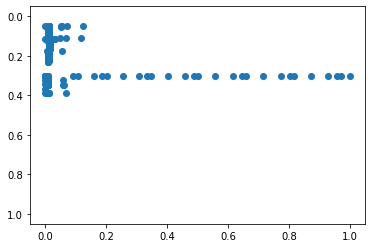

In [293]:
draw_page(all_tag)

In [294]:
label_nodes = [node for node, label in zip(page_positions[target_page], y[target_page]) if label != 'O']

In [295]:
import matplotlib.pyplot as plt

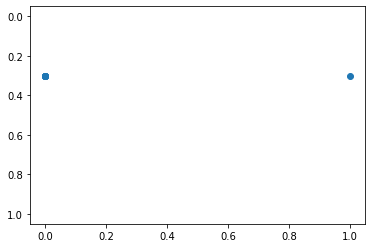

In [296]:
draw_page(label_nodes)